# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter =';')

In [3]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

# check the missing value codes
print(feature_summary[['attribute', 'missing_or_unknown']].head(10))

               attribute missing_or_unknown
0               AGER_TYP             [-1,0]
1   ALTERSKATEGORIE_GROB           [-1,0,9]
2              ANREDE_KZ             [-1,0]
3          CJT_GESAMTTYP                [0]
4      FINANZ_MINIMALIST               [-1]
5          FINANZ_SPARER               [-1]
6       FINANZ_VORSORGER               [-1]
7         FINANZ_ANLEGER               [-1]
8  FINANZ_UNAUFFAELLIGER               [-1]
9       FINANZ_HAUSBAUER               [-1]


In [5]:
def parse_missing_codes(code_string):
    codes = code_string.strip('[]').split(',')
    return [int(code.strip()) for code in codes if code.strip().lstrip('-').isdigit()]

feature_summary['missing_or_unknown_parsed'] = feature_summary['missing_or_unknown'].apply(parse_missing_codes)
print(feature_summary[['attribute', 'missing_or_unknown','missing_or_unknown_parsed']].head(10))

               attribute missing_or_unknown missing_or_unknown_parsed
0               AGER_TYP             [-1,0]                   [-1, 0]
1   ALTERSKATEGORIE_GROB           [-1,0,9]                [-1, 0, 9]
2              ANREDE_KZ             [-1,0]                   [-1, 0]
3          CJT_GESAMTTYP                [0]                       [0]
4      FINANZ_MINIMALIST               [-1]                      [-1]
5          FINANZ_SPARER               [-1]                      [-1]
6       FINANZ_VORSORGER               [-1]                      [-1]
7         FINANZ_ANLEGER               [-1]                      [-1]
8  FINANZ_UNAUFFAELLIGER               [-1]                      [-1]
9       FINANZ_HAUSBAUER               [-1]                      [-1]


In [6]:
for i, row in feature_summary.iterrows():
    feature = row['attribute']
    missing_codes = row['missing_or_unknown_parsed']
    
    if feature in azdias.columns:
        azdias[feature] = azdias[feature].replace(missing_codes, np.nan)
        
    if feature in customers.columns:
        customers[feature] = customers[feature].replace(missing_codes, np.nan)

print('customers dataset: ')
print(customers.head(10))

print('\nCustomers dataset:')
print(customers.head(10))

customers dataset: 
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       2.0                   4.0          1            5.0   
1       NaN                   4.0          1            NaN   
2       NaN                   4.0          2            2.0   
3       1.0                   4.0          1            2.0   
4       NaN                   3.0          1            6.0   
5       1.0                   3.0          1            4.0   
6       2.0                   4.0          1            2.0   
7       1.0                   4.0          1            2.0   
8       2.0                   4.0          2            1.0   
9       1.0                   3.0          1            3.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5              

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_azdias = azdias.isnull().mean()*100
print('\nMissing Data in Azdias dataset:')
print(missing_data_azdias.sort_values(ascending=False))

missing_data_customers = customers.isnull().mean()*100
print('\nMissing Data in Customers dataset:')
print(missing_data_customers.sort_values(ascending=False))


Missing Data in Azdias dataset:
TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_ANTG1               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW      

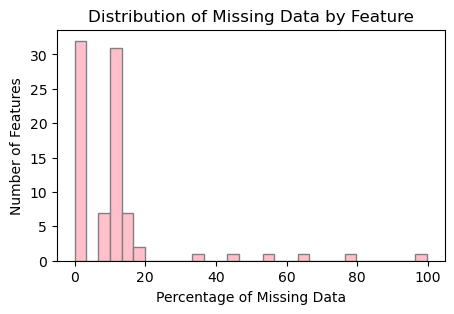

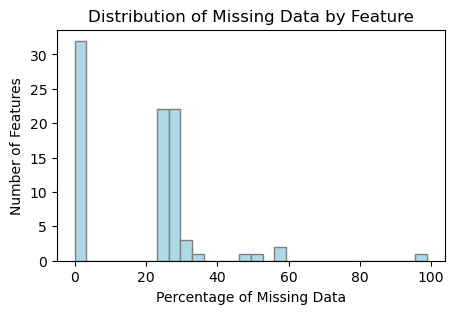

In [8]:
plt.figure(figsize=(5,3))
plt.hist(missing_data_azdias, bins=30, color='pink', edgecolor='grey')
plt.title('Distribution of Missing Data by Feature')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Features')
plt.show()

plt.figure(figsize=(5,3))
plt.hist(missing_data_customers, bins=30, color='lightblue', edgecolor='grey')
plt.title('Distribution of Missing Data by Feature')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Features')
plt.show()

Columns with more than 20% missing data (Azdias): 
 TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64
Columns with more than 20% missing data (Customers): 
 TITEL_KZ                 98.793647
KK_KUNDENTYP             58.406382
KBA05_BAUMAX             57.153069
AGER_TYP                 50.475863
GEBURTSJAHR              48.537975
ALTER_HH                 35.870745
KKK                      31.340137
REGIOTYP                 31.340137
W_KEIT_KIND_HH           29.708534
KBA05_GBZ                29.210235
KBA05_ANTG2              29.209192
KBA05_ANTG3              29.209192
KBA05_ANTG4              29.209192
MOBI_REGIO               29.209192
KBA05_ANTG1              29.209192
PLZ8_ANTG2               27.531150
PLZ8_ANTG3               27.531150
PLZ8_ANTG4               27.531150
PLZ8_BAUMAX              27.531150
PLZ8_HHZ                 27.531150
PLZ8_GBZ              

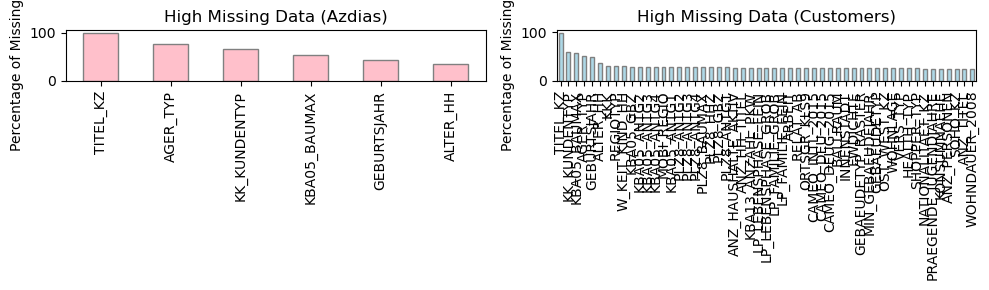

In [9]:
# Investigate patterns in the amount of missing data in each column.
# Columns with more than 20% missing data
high_missing_threshold = 20

high_missing_columns_azdias = missing_data_azdias[missing_data_azdias > high_missing_threshold].sort_values(ascending=False)
print('Columns with more than 20% missing data (Azdias): \n', high_missing_columns_azdias)

high_missing_columns_customers = missing_data_customers[missing_data_customers > high_missing_threshold].sort_values(ascending=False)
print('Columns with more than 20% missing data (Customers): \n', high_missing_columns_customers)

# Visualization of the amount of missing data for these columns
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
high_missing_columns_azdias.plot(kind='bar', color='pink', edgecolor='grey')
plt.title('High Missing Data (Azdias)')
plt.ylabel('Percentage of Missing Data')

plt.subplot(1,2,2)
high_missing_columns_customers.plot(kind='bar', color='lightblue', edgecolor='grey')
plt.title('High Missing Data (Customers)')
plt.ylabel('Percentage of Missing Data')

plt.tight_layout()
plt.show()

In [10]:
num_high_missing_azdias = len(high_missing_columns_azdias)
num_high_missing_customers = len(high_missing_columns_customers)
print(f'Number of columns with more than 20% of missing data in Azdias dataset: {num_high_missing_azdias}')
print(f'Number of columns with more than 20% of missing data in Customers dataset: {num_high_missing_customers}')

high_missing_columns_azdias_set = set(high_missing_columns_azdias.index)
high_missing_columns_customers_set = set(high_missing_columns_customers.index)

missing_in_both = high_missing_columns_azdias_set.issubset(high_missing_columns_customers_set)
print(f'\nAll columns with more than 20% missing in Azdias are also missing in Customers: {missing_in_both}')

if not missing_in_both:
    missing_columns_diff = high_missing_columns_azdias_set - high_missing_columns_customers_set
    print(f'\nColumns with more than 20% missing in Azdias but not in Customers : {missing_columns_diff}')


Number of columns with more than 20% of missing data in Azdias dataset: 6
Number of columns with more than 20% of missing data in Customers dataset: 53

All columns with more than 20% missing in Azdias are also missing in Customers: True


In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns_to_drop = high_missing_columns_azdias.index

azdias_cleaned = azdias.drop(columns=columns_to_drop)
customers_cleaned = customers.drop(columns=columns_to_drop)

# Check the new shape of the Dataframe
print('Shape of the cleaned Azdias Dataframe: ', azdias_cleaned.shape)
print('\nShape of the cleaned Customers Dataframe: ', customers_cleaned.shape)

Shape of the cleaned Azdias Dataframe:  (891221, 79)

Shape of the cleaned Customers Dataframe:  (191652, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

*Report your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?* <br>

Initially I followed the project's suggested structure, applying the cleaning function to the Customers dataset after applying PCA and KMeans to Azdias Dataset. I also didn't delve into further analysis. However, I then recognized a critical discrepancy: the Azdias and Customer datasets had a different number of columns with more than 20% missing values (so the cleaning fuction removed more columns from the Customers dataset than from the Azdias dataset). So the Azdias dataset retained columns that were absent in the Customer dataset. This difference in the structure after cleaning could potentially negatively influence the accurancy of subsequent analyses.<br>
To address this, I ensured that both datasets had an identical set of columns before performing PCA and KMeans.<br>

There are 6 columns with more than 20% missing data in the Azdias dataset.<br>
There are 53 columns with more than 20% missing data in the Customers dataset.<br>
All 6 columns with more than 20% missing data in the Azdias Dataset are also present in the Customers dataset with more than 20% missing data.<br>

I decided to remove 6 columns with more than 20% missing data from both dataset. <br>
The remaining 47 columns with more than 20% missing data in the Customers dataset will be retained in both dataset.<br>
Removing the same columns from both datasets insures consistency in the further analysis.By retaining the other columns with more than 20% missing data in the Customers dataset I ensure that customer data can be compared effectively to the general population.<br>

Moving forward, I will conduct all cleaning and re-encoding activities on both datasets simultaneiusly (if relevant for both). This will ensure that the preprocessing is consistent and accurate for both datasets.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
missing_data_row = azdias_cleaned.isnull().mean(axis=1)*100
print(missing_data_row.head())

0    54.430380
1     0.000000
2     0.000000
3     8.860759
4     0.000000
dtype: float64


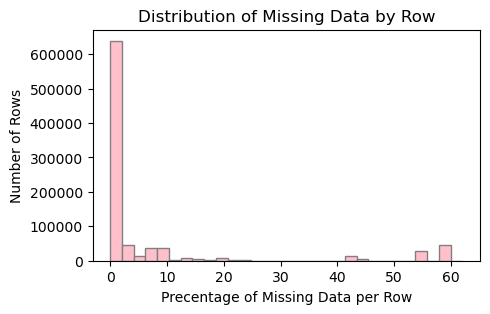

In [13]:
plt.figure(figsize=(5,3))
plt.hist(missing_data_row, bins=30, color='pink', edgecolor='grey')
plt.title('Distribution of Missing Data by Row')
plt.xlabel('Precentage of Missing Data per Row')
plt.ylabel('Number of Rows')
plt.show()

In [14]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
missing_threshold_row = 10
# Subset 1: Rows with missing data above the threshold
subset_high_missing = azdias_cleaned[missing_data_row > missing_threshold_row]
print(f"Number of rows with more that {missing_threshold_row}% missing data: {subset_high_missing.shape[0]}")
# Subset 2: Rows with missing data below the threshold
subset_low_missing = azdias_cleaned[missing_data_row <= missing_threshold_row]
print(f"Number of rows with {missing_threshold_row}% or less missing data: {subset_low_missing.shape[0]}")

Number of rows with more that 10% missing data: 144059
Number of rows with 10% or less missing data: 747162


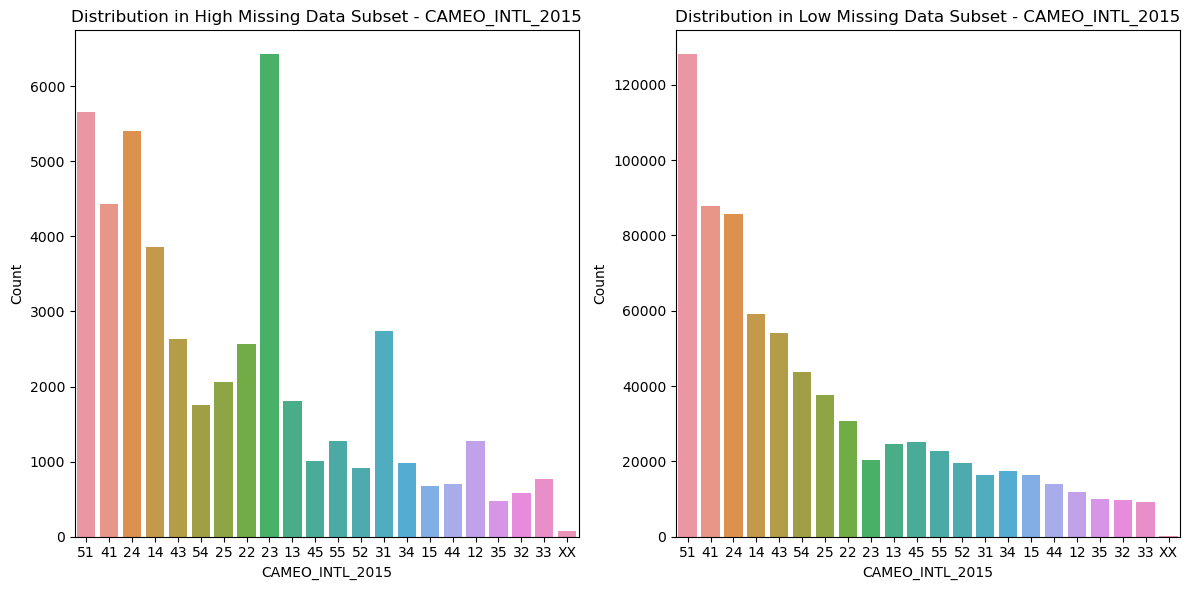

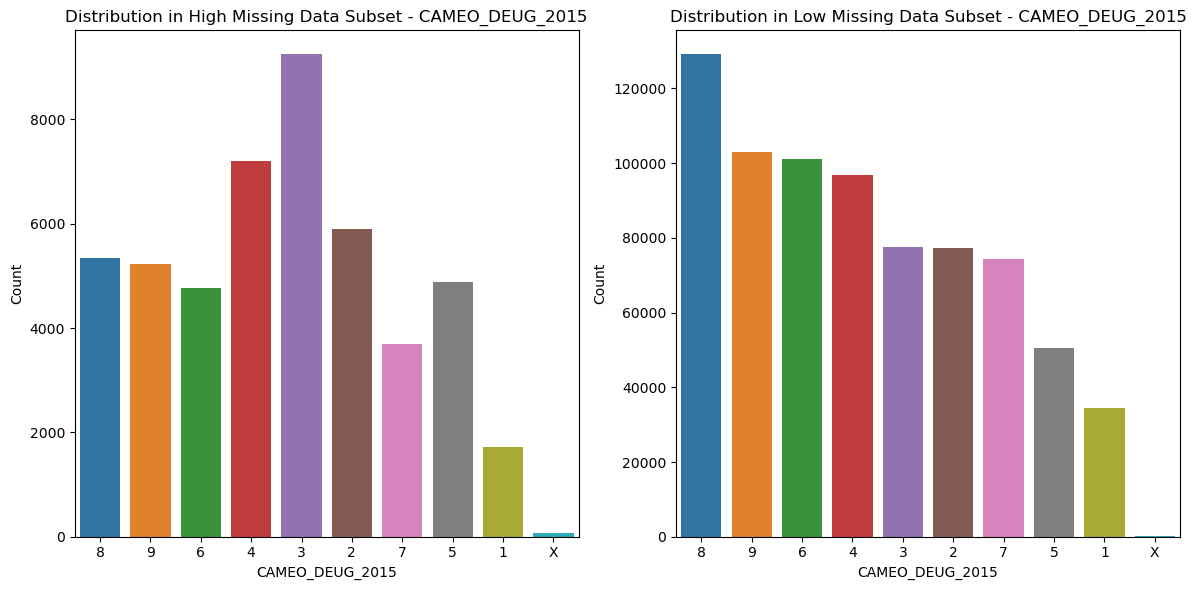

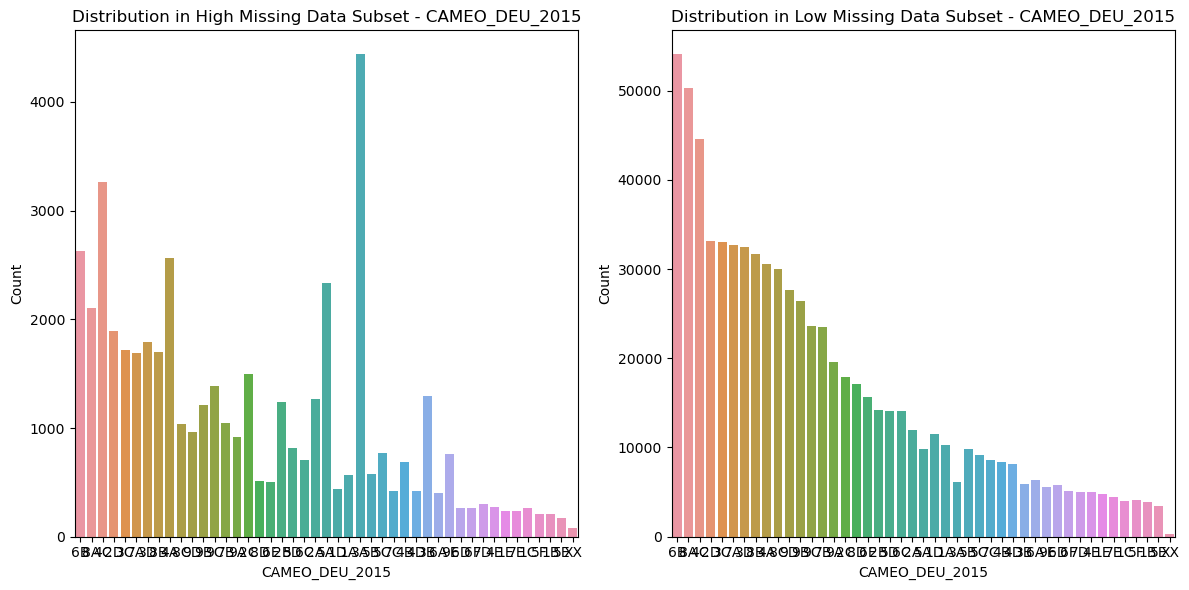

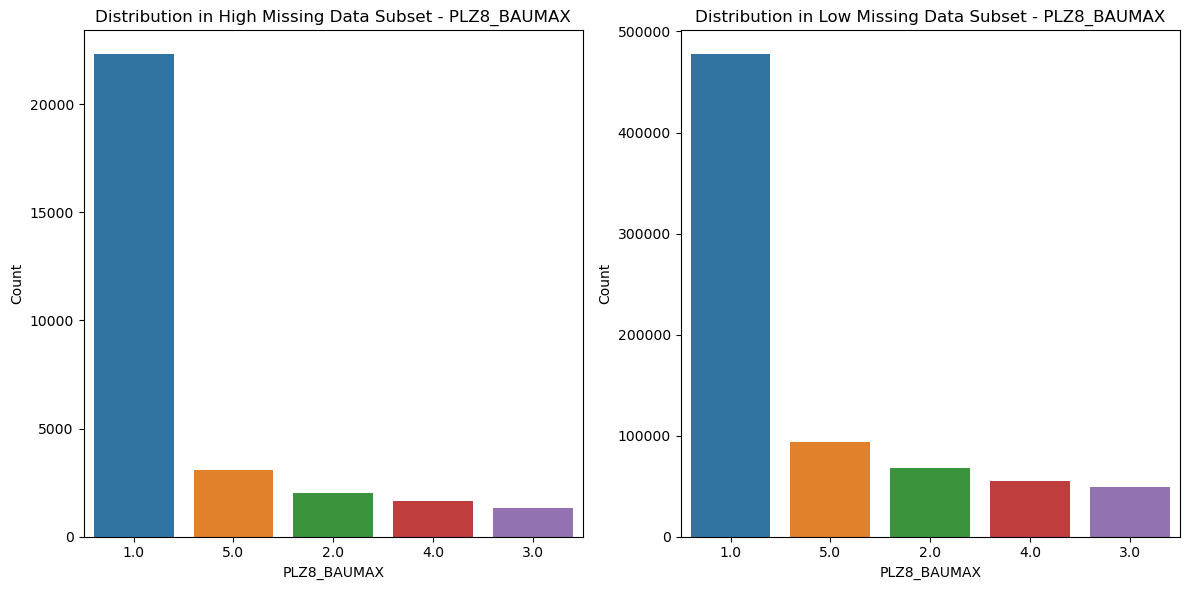

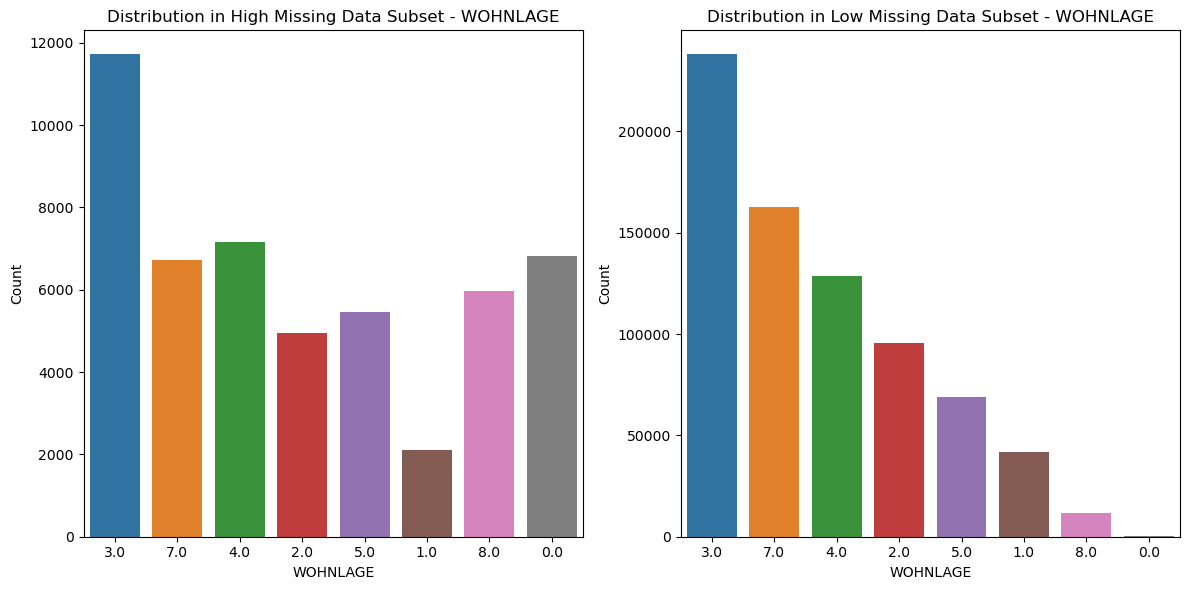

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_distributions(column, subset1, subset2):
    # Sort column categories in descending order in order to simplify the visual
    # inspection of the distribution between the two subsets.
    combined = pd.concat([subset1[column], subset2[column]])
    order = combined.value_counts().index
    
    plt.figure(figsize=(12,6))
    
    # Subplot for subset with high missing values
    plt.subplot(1,2,1)
    sns.countplot(x=column, data=subset1, order=order)
    plt.title(f'Distribution in High Missing Data Subset - {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    # Subplot for subset with low missing values
    plt.subplot(1,2,2)
    sns.countplot(x=column, data = subset2, order=order)
    plt.title(f'Distribution in Low Missing Data Subset - {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
# Select columns to compare 
# After examining the Data_Dictionary.md document I decided to choose the following columns (see code)
# for the comparison. As the goal of the project is to identify the customer segments the columns
# should provide a mix of demographoc, geographic and socio-economic data which I suppose the selected
# columns represent the best
columns_to_compare = ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'PLZ8_BAUMAX', 'WOHNLAGE']
    
# Compare distributions for the selected columns
for column in columns_to_compare:
    compare_distributions(column, subset_high_missing, subset_low_missing)

#### Discussion 1.1.3: Assess Missing Data in Each Row

*(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)*<br>

Most of the rows in the dataset have less than 10% missing values. However, there is still a number of rows with more than 10% missing data.<br>

I decided to compare the distribution of values in the columns CAMEO_INTL_2015, CAMEO_DEUG_2015, CAMEO_DEU_2015, PLZ8_BAUMAX and WOHNLAGE, as I suppose those features are particularly important for identifying customer segments.<br>

While some values are consistently dominant across both datasets (51 for CAMEO_INTL_2015, 1 for PLZ8_BAUMAX and 3 for WOHNLAGE), there are particular differences in the distribution of other values.<br>
The reason for this could be that the rows with high missing values represent different demographic segments or behaviours rather than the rows with low missing values. Thus the rows with high missing values contain unique and important information and simply removing these rows could potentially bias the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
data_types = feature_summary['type'].value_counts()
print(data_types)

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feature_summary[feature_summary['type'] == 'categorical']['attribute']

# Use nunique (ignores NaN values) in order to count the unique values (sporadically checked with Data_Dictionary.md)
for col in categorical_features:
    if col in azdias_cleaned.columns:
        unique_values_azdias = azdias_cleaned[col].nunique()
        print(f'{col}: {unique_values_azdias} unique values')
    else:
        print(f'{col} does not exist in azdias')
    
    if col in customers_cleaned.columns:
        unique_values_customers = customers_cleaned[col].nunique()
        print(f'{col} in customers: {unique_values_customers} unique values')
    else:
        print(f'{col} does not exist in azdias')

AGER_TYP does not exist in azdias
AGER_TYP does not exist in azdias
ANREDE_KZ: 2 unique values
ANREDE_KZ in customers: 2 unique values
CJT_GESAMTTYP: 6 unique values
CJT_GESAMTTYP in customers: 6 unique values
FINANZTYP: 6 unique values
FINANZTYP in customers: 6 unique values
GFK_URLAUBERTYP: 12 unique values
GFK_URLAUBERTYP in customers: 12 unique values
GREEN_AVANTGARDE: 2 unique values
GREEN_AVANTGARDE in customers: 2 unique values
LP_FAMILIE_FEIN: 11 unique values
LP_FAMILIE_FEIN in customers: 11 unique values
LP_FAMILIE_GROB: 5 unique values
LP_FAMILIE_GROB in customers: 5 unique values
LP_STATUS_FEIN: 10 unique values
LP_STATUS_FEIN in customers: 10 unique values
LP_STATUS_GROB: 5 unique values
LP_STATUS_GROB in customers: 5 unique values
NATIONALITAET_KZ: 3 unique values
NATIONALITAET_KZ in customers: 3 unique values
SHOPPER_TYP: 4 unique values
SHOPPER_TYP in customers: 4 unique values
SOHO_KZ: 2 unique values
SOHO_KZ in customers: 2 unique values
TITEL_KZ does not exist in azd

In [18]:
# Ensure the azdias and customers dataset hat the same amount of unique features / columns after using OneHotEncoder
# The result above shows that GEBAEUDETYP hat 7 unique values at azdias but 6 unique values in customers
unique_values_azdias_GEBAEUDETYP = azdias_cleaned['GEBAEUDETYP'].unique()
print(unique_values_azdias_GEBAEUDETYP)
unique_values_customers_GEBAEUDETYP =customers_cleaned['GEBAEUDETYP'].unique()
print(unique_values_customers_GEBAEUDETYP)

[nan  8.  1.  3.  2.  6.  4.  5.]
[ 1. nan  8.  2.  3.  4.  6.]


In [19]:
azdias_cleaned = azdias_cleaned[azdias_cleaned['GEBAEUDETYP'] !=5]

In [20]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_cleaned['OST_WEST_KZ'] = azdias_cleaned['OST_WEST_KZ'].replace({'O': 0, 'W': 1})
customers_cleaned['OST_WEST_KZ'] = customers_cleaned['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

multi_level_categoricals = [col for col in categorical_features if col in azdias_cleaned.columns and azdias_cleaned[col].nunique() > 2]
encoder = OneHotEncoder(sparse_output=False)
encoded_multi_level = pd.DataFrame(encoder.fit_transform(azdias_cleaned[multi_level_categoricals]),
                                  columns=encoder.get_feature_names_out(multi_level_categoricals))
azdias_cleaned2 = azdias_cleaned.drop(columns=multi_level_categoricals)
azdias_cleaned3 = pd.concat([azdias_cleaned2, encoded_multi_level], axis=1)
print('Shape of the encoded DataFrame: ', azdias_cleaned3.shape)

multi_level_categoricals = [col for col in categorical_features if col in  customers_cleaned.columns and customers_cleaned[col].nunique() > 2]
encoder = OneHotEncoder(sparse_output=False)
encoded_multi_level = pd.DataFrame(encoder.fit_transform(customers_cleaned[multi_level_categoricals]),
                                  columns=encoder.get_feature_names_out(multi_level_categoricals))
customers_cleaned2 = customers_cleaned.drop(columns=multi_level_categoricals)
customers_cleaned3 = pd.concat([customers_cleaned2, encoded_multi_level], axis=1)
print('Shape of the encoded DataFrame: ', customers_cleaned3.shape)

Shape of the encoded DataFrame:  (891221, 206)
Shape of the encoded DataFrame:  (191652, 206)


#### Discussion 1.2.1: Re-Encode Categorical Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*<br>

As ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ and VERS_TYP columns were binary (two-level) categories that took numeric values, I kept them withoung changes.<br>
The OST_WEST_KZ column had one binary variable that took on non-numeric values. So I re-encoded them as numbers.<br>
For multi-level categoricals (three or more values), I decided to encode the values using OneHotEncoder.<br>
I decided not to drop any multi-level variables as I can't assess at the current point which of them are irrelevant for the analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias_cleaned3['PRAEGENDE_JUGENDJAHRE'].unique())
print(customers_cleaned3['PRAEGENDE_JUGENDJAHRE'].unique())

# As the number of unique values is equal, I'll perform the engineerung for customers through the clean_data function later

# interval variable
azdias_cleaned3['DECADE'] = azdias_cleaned3['PRAEGENDE_JUGENDJAHRE'].replace({
    1: 1940, 2: 1940, 3: 1950, 4: 1950, 5: 1960, 6: 1960, 7: 1960, 8: 1970, 9: 1970, 10: 1980,
    11: 1980, 12: 1980, 13: 1980, 14: 1990, 15: 1990
})

# binary variable
azdias_cleaned3['MOVEMENT'] = azdias_cleaned3['PRAEGENDE_JUGENDJAHRE'].replace({
    1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
})

print(azdias_cleaned3[['PRAEGENDE_JUGENDJAHRE','DECADE','MOVEMENT']].head(10))

[nan 14. 15.  8.  3. 10. 11.  5.  9.  6.  4.  2.  1. 12. 13.  7.]
[ 4. nan  1.  8.  9.  6. 15. 14. 11.  5.  3.  2. 10. 13. 12.  7.]


   PRAEGENDE_JUGENDJAHRE  DECADE  MOVEMENT
0                    NaN     NaN       NaN
1                   14.0  1990.0       0.0
2                   15.0  1990.0       1.0
3                    8.0  1970.0       0.0
4                    8.0  1970.0       0.0
5                    3.0  1950.0       0.0
6                   10.0  1980.0       0.0
7                    8.0  1970.0       0.0
8                   11.0  1980.0       1.0
9                   15.0  1990.0       1.0


In [22]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_cleaned3['CAMEO_INTL_2015'].unique())
print(customers_cleaned3['CAMEO_INTL_2015'].unique())

# As the number of unique values is equal, I'll perform the engineerung for customers through the clean_data function later

def extract_wealth(value):
    if isinstance(value, str) and value.isdigit():
        return int(value[0])
    return np.nan

def extract_life_stage(value):
    if isinstance(value,str) and value.isdigit():
        return int(value[1])
    return np.nan

azdias_cleaned3['WEALTH'] = azdias_cleaned3['CAMEO_INTL_2015'].apply(extract_wealth)
azdias_cleaned3['LIFE_STAGE'] = azdias_cleaned3['CAMEO_INTL_2015'].apply(extract_life_stage)

print(azdias_cleaned3[['CAMEO_INTL_2015','WEALTH','LIFE_STAGE']].head(20))

[nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']
['13' nan '34' '24' '41' '23' '15' '55' '14' '22' '43' '51' '33' '25' '44'
 '54' '32' '12' '35' '31' '45' '52' 'XX']
   CAMEO_INTL_2015  WEALTH  LIFE_STAGE
0              NaN     NaN         NaN
1               51     5.0         1.0
2               24     2.0         4.0
3               12     1.0         2.0
4               43     4.0         3.0
5               54     5.0         4.0
6               22     2.0         2.0
7               14     1.0         4.0
8               13     1.0         3.0
9               15     1.0         5.0
10              51     5.0         1.0
11             NaN     NaN         NaN
12              43     4.0         3.0
13              33     3.0         3.0
14             NaN     NaN         NaN
15              41     4.0         1.0
16              41     4.0         1.0
17             NaN     NaN         NaN
18              24     2.

#### Discussion 1.2.2: Engineer Mixed-Type Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*<br>

Apart from the columns PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 there are five other columns containing mixed data: LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE, KBA05_BAUMAX and PLZ8_BAUMAX.<br>
I suppose that the columns KBA05_BAUMAX, PLZ8_BAUMAX and WOHNLAGE are less critical for identifying customer segments, so I decided to drop these from the analysis.<br>
Among LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB I determined to keep the broader approximation provided by LP_LEBENSPHASE_GROB, as it offers a higher-level categorization that is sufficient.<br>
Therefore, I'll perform engineering steps for LP_LEBENSPHASE_GROB as I believe the data in this column is particular relevant for understanding customer segments.

In [23]:
# Investigate "LP_LEBENSPHASE_GROB" and engineer three new variables.
print(azdias_cleaned3['LP_LEBENSPHASE_GROB'].unique())
print(customers_cleaned3['LP_LEBENSPHASE_GROB'].unique())

# As the number of unique values is equal, I'll perform the engineerung for customers through the clean_data function later

azdias_cleaned3['HIGH_INCOME'] = azdias_cleaned3['LP_LEBENSPHASE_GROB'].apply(lambda x: 1 if x in [3, 5, 8, 11, 12] else 0)
azdias_cleaned3['HIGHER_AGE'] = azdias_cleaned3['LP_LEBENSPHASE_GROB'].apply(lambda x: 1 if x in [2, 10, 12] else 0)
azdias_cleaned3['MULTIPERSON_HOUSEHOLD'] = azdias_cleaned3['LP_LEBENSPHASE_GROB'].apply(lambda x: 1 if x in [9, 10, 11, 12] else 0)

[ 4.  6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  8.]
[ 5. nan  3. 10.  2.  8. 12. 11.  1.  4.  6.  7.  9.]


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [24]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015','LP_LEBENSPHASE_GROB']
azdias_cleaned4 = azdias_cleaned3.drop(columns=columns_to_drop)

In [25]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# no further steps are needed as missing value were converted into NaNs; selected columns
# with a high percentage of missing data were removed; the column values were re-encoded
# and engineered

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [26]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # remove selected columns and rows with a high percentage of missing data, ...
    # done during the step 1.1.2 
    
    # select, re-encode, and engineer column values.
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].replace({
        1: 1940, 2: 1940, 3: 1950, 4: 1950, 5: 1960, 6: 1960, 7: 1960, 8: 1970, 9: 1970, 10: 1980, 
        11: 1980, 12: 1980, 13: 1980, 14: 1990, 15: 1990
    })
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].replace({
        1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0, 9: 1, 10: 0,
        11: 1, 12: 0, 13: 1, 14: 0, 15: 1
    })
    
    def extract_wealth(value):
        if isinstance(value, str) and value.isdigit():
            return int(value[0])
        return np.nan
    
    def extract_life_stage(value):
        if isinstance(value,str) and value.isdigit():
            return int(value[1])
        return np.nan
     
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(extract_wealth)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(extract_life_stage)
        
    df['HIGH_INCOME'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x: 1 if x in [3, 5, 8, 11, 12] else 0)
    df['HIGHER_AGE'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x: 1 if x in [2, 10, 12] else 0)
    df['MULTIPERSON_HOUSEHOLD'] = df['LP_LEBENSPHASE_GROB'].apply(lambda x: 1 if x in [9, 10, 11, 12] else 0)
    
    columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015','LP_LEBENSPHASE_GROB']
    df = df.drop(columns = columns_to_drop)

    # Return the cleaned dataframe.
    return df

In [27]:
customers_cleaned4 = clean_data(customers_cleaned3)
print(azdias_cleaned4.shape)
print(customers_cleaned4.shape)

(891221, 210)
(191652, 210)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [28]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# check whether there are no non-numeric columns 
non_numeric = azdias_cleaned4.select_dtypes(exclude = ['number']).columns
print(non_numeric)

Index([], dtype='object')


In [29]:
missing_values = azdias_cleaned4.isnull().sum()
print(missing_values)

ALTERSKATEGORIE_GROB       2882
ANREDE_KZ                     1
FINANZ_MINIMALIST             1
FINANZ_SPARER                 1
FINANZ_VORSORGER              1
FINANZ_ANLEGER                1
FINANZ_UNAUFFAELLIGER         1
FINANZ_HAUSBAUER              1
GREEN_AVANTGARDE              1
HEALTH_TYP               111197
LP_LEBENSPHASE_FEIN       97633
RETOURTYP_BK_S             4855
SEMIO_SOZ                     1
SEMIO_FAM                     1
SEMIO_REL                     1
SEMIO_MAT                     1
SEMIO_VERT                    1
SEMIO_LUST                    1
SEMIO_ERL                     1
SEMIO_KULT                    1
SEMIO_RAT                     1
SEMIO_KRIT                    1
SEMIO_DOM                     1
SEMIO_KAEM                    1
SEMIO_PFLICHT                 1
SEMIO_TRADV                   1
SOHO_KZ                   73500
VERS_TYP                 111197
ANZ_PERSONEN              73500
ANZ_TITEL                 73500
HH_EINKOMMEN_SCORE        18349
W_KEIT_K

In [30]:
missing_percentage = azdias_cleaned4.isnull().sum() / len(azdias) * 100
print(missing_percentage)

ALTERSKATEGORIE_GROB      0.323377
ANREDE_KZ                 0.000112
FINANZ_MINIMALIST         0.000112
FINANZ_SPARER             0.000112
FINANZ_VORSORGER          0.000112
FINANZ_ANLEGER            0.000112
FINANZ_UNAUFFAELLIGER     0.000112
FINANZ_HAUSBAUER          0.000112
GREEN_AVANTGARDE          0.000112
HEALTH_TYP               12.476928
LP_LEBENSPHASE_FEIN      10.954971
RETOURTYP_BK_S            0.544758
SEMIO_SOZ                 0.000112
SEMIO_FAM                 0.000112
SEMIO_REL                 0.000112
SEMIO_MAT                 0.000112
SEMIO_VERT                0.000112
SEMIO_LUST                0.000112
SEMIO_ERL                 0.000112
SEMIO_KULT                0.000112
SEMIO_RAT                 0.000112
SEMIO_KRIT                0.000112
SEMIO_DOM                 0.000112
SEMIO_KAEM                0.000112
SEMIO_PFLICHT             0.000112
SEMIO_TRADV               0.000112
SOHO_KZ                   8.247113
VERS_TYP                 12.476928
ANZ_PERSONEN        

In [31]:
print(azdias_cleaned4.shape)

imputer = SimpleImputer(strategy = 'mean')

azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_cleaned4), columns=azdias_cleaned4.columns)

print(azdias_imputed.shape)

(891221, 210)
(891221, 210)


In [32]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns=azdias_imputed.columns)

print(azdias_scaled.shape)

(891221, 210)


### Discussion 2.1: Apply Feature Scaling

*(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)*<br>

Before applying dimensional reduction techniques it was necessary to adress the issue with missing values and ensure consistend feature scaling.<br>
I decided to apply a SimpleImputer and replace the missing values with the mean of each feature.<br>
I used then StandardScaler to prevent the features with larger scales from disproportionally influencing the further clustering process.<br>
This approach allows to capture the true structure of the data and derive accurate results.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

print(f'Original shape {azdias_scaled.shape}')
      
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)
      
print(f'Transformed shape {azdias_pca.shape}')

Original shape (891221, 210)
Transformed shape (891221, 210)


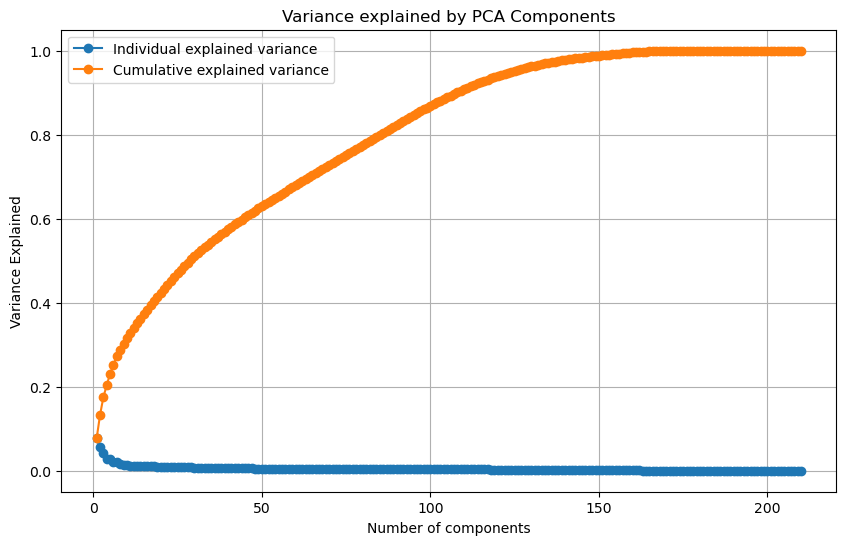

In [34]:
# Investigate the variance accounted for by each principal component.

variance_explained = pca.explained_variance_ratio_
variance_cumulative = variance_explained.cumsum()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(variance_explained) +  1), variance_explained, marker ='o', label='Individual explained variance')
plt.plot(range(1, len(variance_cumulative) + 1), variance_cumulative, marker='o', label='Cumulative explained variance')
plt.xlabel('Number of components')
plt.ylabel('Variance Explained')
plt.title('Variance explained by PCA Components')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = (variance_cumulative < 0.90).sum() + 1
print(f'Number of components to retain 90% variance: {n_components}')

pca2 = PCA(n_components)
azdias_pca2 = pca2.fit_transform(azdias_scaled)

print(f'Shape of the reduced dataset: {azdias_pca2.shape}')

Number of components to retain 90% variance: 108
Shape of the reduced dataset: (891221, 108)


### Discussion 2.2: Perform Dimensionality Reduction

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)*<br>

The initial analysis of the variance suggests that a large number of components is required in order to capture the majority of the variance. <br>
The plot above shows that the first 90% of the variance is captured by approximately 105-120 components (further analysis revealed the number of 108). The remaining 10% is spread across nearly 45% of the components. Including these components into further analysis would unnecessary complicate the dataset without providing significant additional information. Therefore I decided to retain only 108 components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [36]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
feature_names= azdias_scaled.columns

def sorted_feature_weights(pca2, component_num, feature_names, top_n=10):
    component_weights = pca2.components_[component_num]
    component_df = pd.DataFrame({'feature': feature_names, 'weight': component_weights})
    component_df = component_df.sort_values(by='weight', ascending=False)
    print(f'Principal Component {component_num + 1}:')
    print(f'\nTop {top_n} positive features:')
    print(component_df.head(top_n).to_string(index=False))
    print(f'\nTop {top_n} negative features:')
    print(component_df.tail(top_n).to_string(index=False))

sorted_feature_weights(pca2, component_num=0, feature_names=feature_names)

Principal Component 1:

Top 10 positive features:
           feature   weight
LP_STATUS_GROB_1.0 0.178981
        PLZ8_ANTG3 0.178978
            WEALTH 0.178666
        PLZ8_ANTG4 0.173596
       PLZ8_BAUMAX 0.169197
HH_EINKOMMEN_SCORE 0.153765
       ORTSGR_KLS9 0.152804
          EWDICHTE 0.151270
  FINANZ_HAUSBAUER 0.145643
       KBA05_ANTG4 0.123882

Top 10 negative features:
            feature    weight
         INNENSTADT -0.125464
           PLZ8_GBZ -0.131186
        KONSUMNAEHE -0.133259
LP_LEBENSPHASE_FEIN -0.134935
        HIGH_INCOME -0.175230
          KBA05_GBZ -0.176768
         PLZ8_ANTG1 -0.179320
  FINANZ_MINIMALIST -0.180960
        KBA05_ANTG1 -0.185972
         MOBI_REGIO -0.198876


In [37]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_feature_weights(pca2, component_num=1, feature_names=feature_names)

Principal Component 2:

Top 10 positive features:
             feature   weight
ALTERSKATEGORIE_GROB 0.198393
    FINANZ_VORSORGER 0.193603
           SEMIO_ERL 0.153923
          HIGHER_AGE 0.152805
NATIONALITAET_KZ_1.0 0.140810
      RETOURTYP_BK_S 0.135987
          SEMIO_LUST 0.111713
      W_KEIT_KIND_HH 0.107062
         FINANZTYP_5 0.106993
  LP_STATUS_FEIN_1.0 0.104818

Top 10 negative features:
              feature    weight
      GEBAEUDETYP_nan -0.149202
   LP_STATUS_FEIN_5.0 -0.152112
            SEMIO_RAT -0.155798
          FINANZTYP_4 -0.164219
        SEMIO_PFLICHT -0.187565
               DECADE -0.192237
            SEMIO_REL -0.212972
        FINANZ_SPARER -0.220414
       FINANZ_ANLEGER -0.226881
FINANZ_UNAUFFAELLIGER -0.232937


In [38]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_feature_weights(pca2, component_num=2, feature_names=feature_names)

Principal Component 3:

Top 10 positive features:
             feature   weight
          ZABEOTYP_3 0.224812
     GEBAEUDETYP_nan 0.221076
 CAMEO_DEUG_2015_nan 0.216922
  CAMEO_DEU_2015_nan 0.216922
NATIONALITAET_KZ_nan 0.210096
     SHOPPER_TYP_nan 0.207744
          SEMIO_KRIT 0.199032
 LP_FAMILIE_GROB_nan 0.180509
 LP_FAMILIE_FEIN_nan 0.180509
          SEMIO_KAEM 0.171830

Top 10 negative features:
             feature    weight
     SHOPPER_TYP_0.0 -0.096050
         FINANZTYP_1 -0.106907
          ZABEOTYP_4 -0.107303
NATIONALITAET_KZ_1.0 -0.109652
   ONLINE_AFFINITAET -0.123492
              DECADE -0.150249
         SEMIO_TRADV -0.167062
           SEMIO_SOZ -0.183096
          SEMIO_VERT -0.188514
          SEMIO_KULT -0.215606


### Discussion 2.3: Interpret Principal Components

*(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)*

The positive values of the first principal component are dominated by features like LP_STATUS_GROB_1.0 (Social status low-income earners), PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region), WEALTH (from CAMEO_INTL_2015), PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region) and PLZ8_BAUMAX (Most common building type within the PLZ8 region). The negative values constist of MOBI_REGIO, KBA05_ANTG1, FINANZ_MINIMALIST, PLZ8_ANTG1 and KBA05_GBZ. <br>
This suggests that PC1 captures a contrast between suburban areas with a mix of wealth and socio-economic diversity and urban areas that are more densily populated and closer to city centers.

The positive values of the second principal component are dominated by features like ALTERSKATEGORIE_GROB (Estimated age based on given name analysis), FINANZ_VORSORGER, SEMIO_ERL (event-oriented), HIGHER_AGE. The negative values consist of FINANZ_UNAUFFAELLIGER, FINANZ_ANLEGER, FINANZ_SPARER, SEMIO_REL and DECADE. <br>
This suggests that PC2 captures a contrast between older financially conservative individuals and younger possibly less established individuals who may be less financially engaged. 

The positive values of the second principal component are dominated by features like ZABEOTYP_3, GEBAEUDETYP_nan, CAMEO_DEUG_2015_nan, CAMEO_DEU_2015_nan and NATIONALITAET_KZ_nan.  The negative values consist of SEMIO_KULT, SEMIO_VERT, SEMIO_SOZ, SEMIO_TRADV and DECADE.<br>
This suggests that PC3 captures a contrast between individuals with incomplete or missing data and those with well-defined, complete characteristics.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [39]:
# Over a number of different cluster counts...

    # run k-means clustering on the data and...
    
    # compute the average within-cluster distances.

from sklearn.cluster import KMeans

cluster_counts = range(2,20)
average_distances = []

for k in cluster_counts:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias_pca2)

    average_distances.append(-kmeans.score(azdias_pca2) / len(azdias_pca2)) 

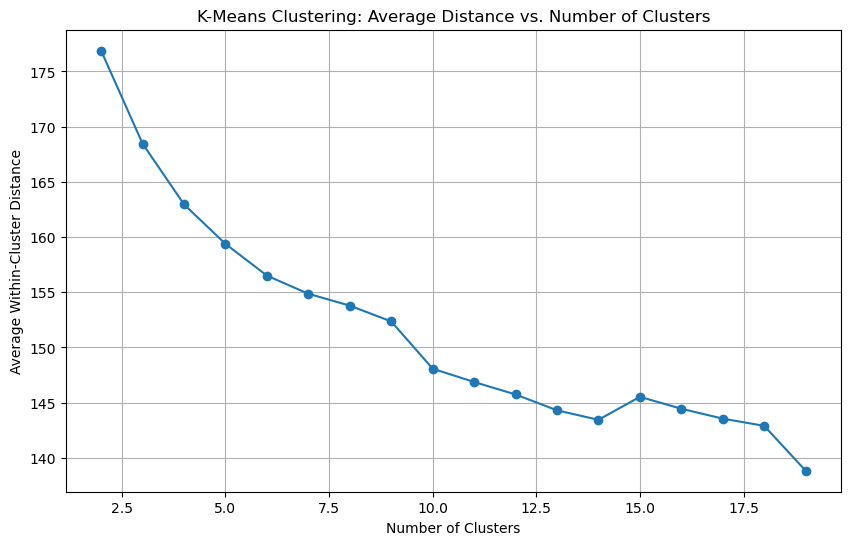

In [40]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10,6))
plt.plot(cluster_counts, average_distances, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.title('K-Means Clustering: Average Distance vs. Number of Clusters')
plt.grid(True)
plt.show()

In [41]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
optimal_clusters = 11

final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
azdias_clusters = final_kmeans.fit_predict(azdias_pca2)

print(f'Cluster Assignment for the General Population Data: {np.unique(azdias_clusters)}')

Cluster Assignment for the General Population Data: [ 0  1  2  3  4  5  6  7  8  9 10]


### Discussion 3.1: Apply Clustering to General Population

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)*<br>

I used the elbow method in order to examine the relationship between the number of clusters and the average within-cluster distance. The plot above revealed that the rate of decrease starts to slow down around the 11th cluster. Based on this analysis I decided to segment the general population into 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [42]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Cleaning already done at step 1.3

customers_imputed = pd.DataFrame(imputer.transform(customers_cleaned4), columns=customers_cleaned4.columns)

customers_scaled = scaler.transform(customers_imputed)

customers_scaled2 = pd.DataFrame(customers_scaled, columns=customers_imputed.columns)
customers_scaled2 = customers_scaled2[azdias_scaled.columns]

customers_pca = pca2.transform(customers_scaled2)

customer_clusters = final_kmeans.predict(customers_pca)

print(f'Cluster Assignment for the Customer Population Data: {np.unique(customer_clusters)}')

Cluster Assignment for the Customer Population Data: [ 0  1  2  3  4  5  6  7  8  9 10]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Overrepresented Clusters: 
    Cluster  General Population  Customers  Difference
0        0            0.084206   0.243587    0.159382
1        1            0.005446   0.016765    0.011318
2        2            0.129440   0.321150    0.191709
3        3            0.137783   0.168707    0.030924
6        6            0.007976   0.009095    0.001119
Underrepresented Clusters: 
     Cluster  General Population  Customers  Difference
4         4            0.098179   0.062327   -0.035852
5         5            0.115172   0.081418   -0.033754
7         7            0.125319   0.021977   -0.103342
8         8            0.090456   0.060010   -0.030446
9         9            0.084340   0.006616   -0.077724
10       10            0.121683   0.008348   -0.113334


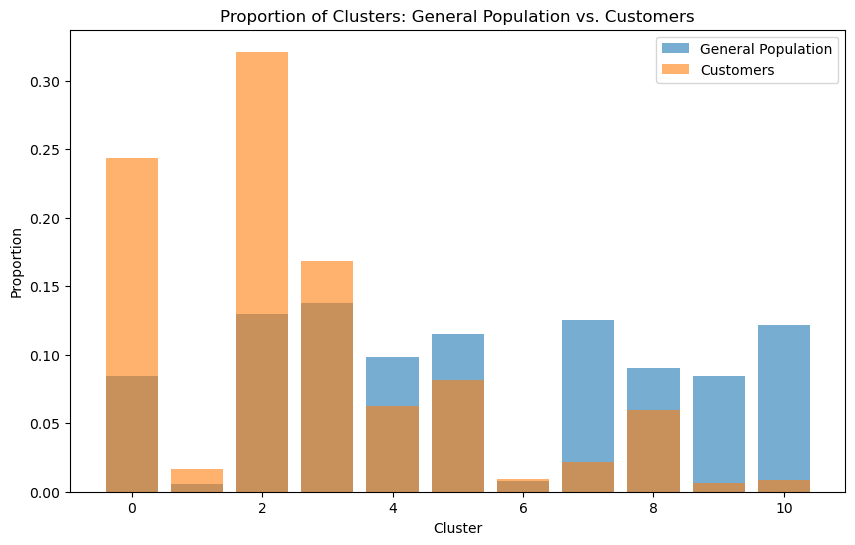

In [43]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_clusters, azdias_clusters_counts = np.unique(azdias_clusters, return_counts=True)
azdias_clusters_proportions = azdias_clusters_counts / azdias_clusters_counts.sum()

customer_clusters, customer_counts = np.unique(customer_clusters, return_counts=True)
customer_proportions = customer_counts / customer_counts.sum()

max_clusters = max(len(azdias_clusters_proportions), len(customer_proportions))
cluster_labels = np.arange(max_clusters)

cluster_proportions = pd.DataFrame({
    'Cluster': cluster_labels,
    'General Population': np.zeros(max_clusters),
    'Customers': np.zeros(max_clusters)
})

cluster_proportions.loc[:len(azdias_clusters_proportions) - 1, 'General Population'] = azdias_clusters_proportions
cluster_proportions.loc[:len(customer_proportions) - 1, 'Customers'] = customer_proportions

cluster_proportions['Difference'] = cluster_proportions['Customers'] - cluster_proportions['General Population']

overrepresented_clusters = cluster_proportions[cluster_proportions['Difference'] > 0]
print('Overrepresented Clusters: \n', overrepresented_clusters)

underrepresented_clusters = cluster_proportions[cluster_proportions['Difference'] < 0]
print('Underrepresented Clusters: \n', underrepresented_clusters)

plt.figure(figsize=(10,6))
plt.bar(range(len(azdias_clusters_proportions)), azdias_clusters_proportions, alpha=0.6, label='General Population')
plt.bar(range(len(customer_proportions)), customer_proportions, alpha=0.6, label='Customers')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend()
plt.title('Proportion of Clusters: General Population vs. Customers')
plt.show()

In [44]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_0_centroid = final_kmeans.cluster_centers_[0]
cluster_0_centroid_reshaped = cluster_0_centroid.reshape(1,-1)
cluster_0_original_space = pca2.inverse_transform(cluster_0_centroid_reshaped)
cluster_0_features = scaler.inverse_transform(cluster_0_original_space)
cluster_0_df = pd.DataFrame(cluster_0_features, columns=customers_imputed.columns)
print(cluster_0_df)

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              2.362529   1.553334           3.044403       3.984719   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          2.964291        4.973173                4.98456           2.90408   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  RETOURTYP_BK_S  \
0         -0.005515    2.212158            17.005887        3.249606   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0    1.98736   5.904439   6.978562   5.018583    1.166465    5.027402   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0   3.148143    3.037328   4.101821    6.940705   5.919318    5.927499   

   SEMIO_PFLICHT  SEMIO_TRADV   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  \
0       5.158181     2.920164  0.008283  1.517994       1.72106   0.003817   

   HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  \
0            2.144

In [45]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_0_centroid = final_kmeans.cluster_centers_[10]
cluster_0_centroid_reshaped = cluster_0_centroid.reshape(1,-1)
cluster_0_original_space = pca2.inverse_transform(cluster_0_centroid_reshaped)
cluster_0_features = scaler.inverse_transform(cluster_0_original_space)
cluster_0_df = pd.DataFrame(cluster_0_features, columns=customers_imputed.columns)
print(cluster_0_df)

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              1.846534   1.981278           1.145933       4.446936   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0          2.234176        4.408274               3.878683          4.271859   

   GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  RETOURTYP_BK_S  \
0          0.044388    2.221896            10.955064        2.595932   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0   3.201337   3.919951   5.310227   4.659559    2.282472    3.331815   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0   4.435812    3.979153   5.861174    5.491285   6.036499    6.018257   

   SEMIO_PFLICHT  SEMIO_TRADV   SOHO_KZ  VERS_TYP  ANZ_PERSONEN  ANZ_TITEL  \
0       5.935058     5.239255  0.007725  1.475273      1.430383   0.001587   

   HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  \
0            5.467

### Discussion 3.3: Compare Customer Data to Demographics Data

*(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)*<br>

The plot above shows that clusters 0, 1, 2, 3 and 6 significantly higher proportion of customers than the general population, indicating that these clusters represent key target segments for the company.<br>
I decided to analyse the individuals in the overrepresented cluster 0.<br>
According to the features the individuals are likely to be around 30 - 45 years old (ALTERSKATEGORIE_GROB 2.362529), Comfortable Households - Families With School Age Children (WEALTH  3.25935; LIFE_STAGE 2.864661), financially prepared (FINANZTYP_4 0.968965), minimalistic high-income earners (LP_STATUS_FEIN_5.0 0.630607).<br>

On the other hand, clusters 4, 5, 7, 8, 9 and 10 have a higher proportion in the general population than among the customers which suggests these groups are less engaged with the company's products or services.<br>
I decided to analyse the individuals in the underrepresented cluster 10.<br>
According to the features the individuals are likely to be around 30 - 45 years old (ALTERSKATEGORIE_GROB 1.846534), Less Affluent Households - Young Couples With Children (WEALTH  4.174808; LIFE_STAGE 2.203086), low financial interest (MINIMALIST) (FINANZTYP_1 0.797009), orientation-seeking low-income earners (LP_STATUS_FEIN_2.0 0.654974).<br>

The company's marketing activities may be more effective when concentrated on particular demographic segments (overrepresented clusters), as the company's products and services appear to be more appealing among these individuals.<br>

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.